<a href="https://colab.research.google.com/github/akhil-gun/DSI/blob/master/shroomed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SHROOMER: Simple Mushroom Edibility Classifier**

Part of the DSI 2022 Module 1 twist challenge.

## Context
When I go hiking and stumble upon some mushrooms, i always wonder if they are edible are not. Since nearly everyone carries a phone with them, a nice app would be to have an image classifier suggesting which mushrooms would be edible, and which would be poisonous.

## Goals: 

Get experience with: 
*   getting and cleaning your own data (webscraping, APIs)
*   Building ML demos 
*   Fine-tuning pretrained models 
*   Presenting and communicating your work 

## Meta Goals: 

*   Practise living by the 80-20 rule and finding the most valuable things to do in a limited time and under pressure 
*   Explore your interests within data science and AI
*   Understand what the full ML lifecycle looks like

## Time constraint
46 hrs

## Future works
*   Proper webscraping
*   Larger and more detailed dataset. Explore other sources such as Fungipedia
*   Data augmentation
*   Hyperparameter fine-tuning
*   Better web app UI
*   Adding a third class: inedible
*   Potentially expanding this to edible vs poisonous plants in general

## References
1.   https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
2.   https://www.pluralsight.com/guides/image-classification-with-pytorch
3.   https://gradio.app/docs/
4.   https://www.mushroom.world/ 








In [1]:
# Importing necessary libraries

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Mounting google drive to access data

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Accessing the mushroom image dataset
data_dir = '/content/drive/MyDrive/Shroomer/data/'

!ls '/content/drive/MyDrive/Shroomer/data/'

sample	train  val


## EDA

In [4]:
# Processing the images for display

data_process = {
    'train': transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((500, 500)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

processed_images = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_process[x])
                  for x in ['train', 'val']}

dataloaders_base = {x: torch.utils.data.DataLoader(processed_images[x], batch_size=4,
                            shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(processed_images[x]) for x in ['train', 'val']}
class_names = processed_images['train'].classes   

print(dataset_sizes)
print(class_names)

{'train': 146, 'val': 87}
['edible', 'poisonous']


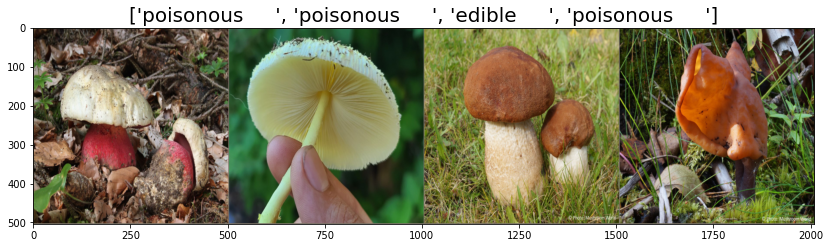

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize = '20')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders_base['train']))

print(dataloaders_base['train'])

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title_list = [class_names[x] + '     ' for x in classes]

fig = plt.figure(figsize=(14,8))
imshow(out, title=title_list)

In [6]:
print(dataset_sizes)

{'train': 146, 'val': 87}


In [7]:
print(class_names)

['edible', 'poisonous']


In [8]:
# Getting paths of sub-directories
train_path = data_dir + 'train/'
val_path = data_dir + 'val/'
#!ls '/content/drive/MyDrive/Shroomer/data/train/'

train_poisonous = train_path + 'poisonous/'
train_edible = train_path + 'edible/'
val_poisonous = val_path + 'poisonous/'
val_edible = val_path + 'edible/'

edible = [train_edible, val_edible]
poisonous = [train_poisonous, val_poisonous]

# Getting total count of edible mushrooms
edible_count = 0
for i in range(0, len(edible)):
  path, dirs, files = next(os.walk(edible[i]))
  edible_count += len(files)
  #print(edible_count)

# Getting total count of poisonous mushrooms
poisonous_count = 0
for i in range(0, len(edible)):
  path, dirs, files = next(os.walk(poisonous[i]))
  poisonous_count += len(files)

print('Total number of edible mushrooms: ', edible_count)
print('Total number of poisonous mushrooms: ', poisonous_count)

total_count = [edible_count, poisonous_count]

Total number of edible mushrooms:  124
Total number of poisonous mushrooms:  109


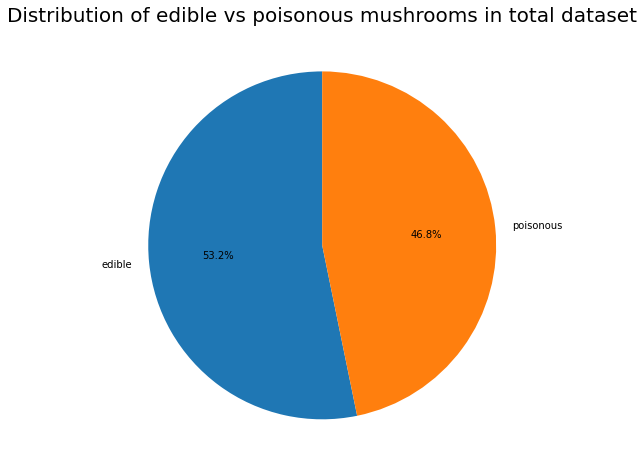

In [9]:
# Visualising the dataset repartition
plt.figure(figsize = (8,8))
plt.pie(total_count, labels = class_names, autopct='%1.1f%%', shadow=False, startangle=90)
plt.title('Distribution of edible vs poisonous mushrooms in total dataset', fontsize = '20')
plt.show()

## Training

In [10]:
# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation

num_workers = 2

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((500, 500)),
        #transforms.RandomResizedCrop(224),
        #transforms.Resize(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((500, 500)),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=num_workers)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

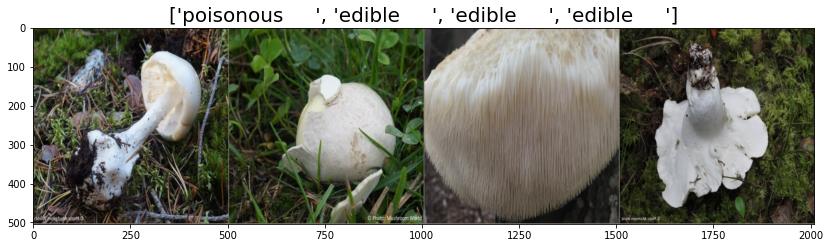

In [12]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

print(dataloaders['train'])

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

title_list = [class_names[x] + '     ' for x in classes]

# Visualising training data and augmentations
fig = plt.figure(figsize=(14,8))
imshow(out, title=title_list)


In [13]:
epoch_no = 1

In [14]:
# Defining training function to schedule the learning rate and save best model

def train_model(model, criterion, optimizer, scheduler, num_epochs=epoch_no):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
# Defining function to visualise images with their predictions compared to ground truth

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(6,6))
    

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]) + 
                             '\nActual: {}'.format(class_names[labels[j]]), 
                             fontsize = '16')         
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning the CNN
Loading the Resnet18 pretrained model.

Resetting final fully connected layer.

In [16]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# Training and evaluating
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epoch_no)

Epoch 0/0
----------
train Loss: 0.7449 Acc: 0.5137


In [ ]:
# Call the function
visualize_model(model_ft)

In [ ]:
# Freezing whole network except final layer. 
# Set requires_grad = False to freeze the parameters so that the gradients are not computed in backward()

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
# Training and evaluating
# usually takes less time than previous training since most gradients do not need to be computed for most of network
# note: forward is still computed
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=epoch_no)

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [ ]:
# Save 
torch.save(model_conv.state_dict(), 'model_conv.ckpt')

**WEB APP**

In [ ]:
!pip install --quiet gradio

In [ ]:
model_path = 'model_conv.ckpt'
state_dict = torch.load(model_path)
#print(state_dict.keys())
model_conv.load_state_dict(state_dict)
model_conv.eval()

In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import PIL

import gradio as gr
import torch
from torchvision import transforms
import requests
from PIL import Image

sample = '/content/drive/My Drive/Shroomer/data/sample/'

labels = ['Edible', 'Poisonous']

def predict_image(Input):
  Input = Image.fromarray(Input.astype('uint8'), 'RGB')
  Input = transforms.ToTensor()(Input).unsqueeze(0)
  with torch.no_grad():
    prediction = torch.nn.functional.softmax(model_conv(Input)[0], dim=0)
  return {labels[i]: float(prediction[i]) for i in range(2)}

image = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=2)
gr.Interface(fn=predict_image, inputs=image, outputs=label).launch()
title = 'Mushrooms: To eat or not to eat?'
description = 'DISCLAIMER: Proof-of-concept MVP!'
examples=[['samples/Agaricusarvensis7.jpg'],
          ['samples/Agaricusaugustus3.jpg'],
          ['samples/Amanitajacksonii4.jpg'],
          ['samples/Amanitaphalloides4.jpg'],
          ['samples/Hebelomamesophaeum4.jpg'],
          ['samples/Galerinamarginata4.jpg']]
thumbnail = 'thumbnail.jpg'
article = '''
<!DOCTYPE html>
<html>
<body>
<br>
<p>
Mushroom images and categories obtained from: <a href="https://www.mushroom.world/"> Mushroom World</a>
</p>
<br>
<p><i>By: Akhil Gunessee</i></p> 
</body>
</html>
'''

iface = gr.Interface(fn=predict_image, 
                     inputs=image, 
                     outputs=label,
                     interpretation='default',
                     title = title,
                     description = description,
                     theme = 'darkpeach',
                     examples = examples,
                     thumbnail = thumbnail,
                     article = article,
                     allow_flagging = False,
                     allow_screenshot = False,                     
                    )
iface.launch()